<a href="https://colab.research.google.com/github/KimyYoungWook/DataScience/blob/main/practice/KNeighborsClassifier_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89%EC%83%9D%EC%A1%B4%EC%9E%90_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문제 정의 : KNeighborsClassifier 사용하여 타이타닉생존자(1),사망(0)  예측

기본라이브러리 불러오기

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


[Step 1] 데이터 준비 - Seaborn에서 제공하는 titanic 데이터셋 가져오기

In [3]:
# load_dataset 함수 사용하여 데이터 프레임으로 변환
df = sns.load_dataset('titanic')

In [4]:
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [6]:
# NaN값이 많은 deck(객실 데크 위치) 열을 삭제, embarked와 내용이 겹치는 embark_town(승선 도시) 열을 삭제

rdf = df.drop(['deck','embark_town'], axis=1)

In [7]:
#age 열에 나이 데이터가 없는 모든 행을 삭제 ->177 개 NaN삭제
rdf = rdf.dropna(subset=['age'], how= 'any', axis=0)

In [8]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값 확인 -> 탑승한 도시의 첫글자
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
most_freq

'S'

In [9]:
rdf['embarked'].fillna(most_freq, inplace =True)

In [10]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


[Step3] 분석에 사용할 속성을 선택

In [11]:
# 분석에 활용할 열(속성) 선택( 생존여부, 객실 등급, 성별,나이,
#타이타닉에 탑승한 형제 자매수, 타이타닉에 탑승한 붐모/자녀수 탑승한곳(항구), C=Cherbourg, Q =Queentstown, S =Southampton)
ndf = rdf[['survived','pclass','sex','age','sibsp','parch','embarked']]
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [12]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할수 있도록 숫자형으로 변경
# male,female -> [1,0],[0,1]
# embarked C, Q ,S -> [1,0,0],[0,1,0],[0,0,1]

onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf,onehot_sex], axis =1)
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked,female,male
0,0,3,male,22.0,1,0,S,0,1
1,1,1,female,38.0,1,0,C,1,0
2,1,3,female,26.0,0,0,S,1,0
3,1,1,female,35.0,1,0,S,1,0
4,0,3,male,35.0,0,0,S,0,1


[step4] 데이터셋 구분  - 훈련용(train data)/검증용(test data)

In [13]:
# embarked C, Q ,S -> [1,0,0],[0,1,0],[0,0,1]
onehot_embarked = pd.get_dummies(ndf['embarked'],prefix='town')
ndf = pd.concat([ndf,onehot_embarked],axis=1)

In [14]:
ndf.drop(['sex','embarked'],axis=1,inplace=True)
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


In [15]:
# ndf -> X,y(문제집,정답지)
X = ndf[['pclass','age','sibsp','parch','female','male','town_C','town_Q','town_S']] # 독립변수
y = ndf['survived']

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
print(X_train.shape)
print(X_test.shape)

(499, 9)
(215, 9)


[step5] KNN 분류 모형 -  sklearn 사용

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k= 5로 설정)
knn =KNeighborsClassifier(n_neighbors=5)

In [21]:
# train 데이터를 사용하여 모형 학습
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [22]:
# test 데이터를 가지고 y_hat을 예측
y_hat = knn.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 0 1 1 0 0 0 0 0]
[0 1 0 1 0 0 1 0 0 0]


모델 성능 평가

In [23]:
from sklearn import metrics

# 모형 성능 평가 - 평가지표 계산
knn_report = metrics.classification_report(y_test,y_hat)
print("테스트 평가지표: n_neighbors =5")
print(knn_report)

테스트 평가지표: n_neighbors =5
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       126
           1       0.78      0.69      0.73        89

    accuracy                           0.79       215
   macro avg       0.79      0.78      0.78       215
weighted avg       0.79      0.79      0.79       215



In [24]:
# sklearn 을 이용하면 전부 계산
print('accuracy: ',metrics.accuracy_score(y_test,y_hat))
print('precision: ',metrics.precision_score(y_test,y_hat))
print('recall: ', metrics.recall_score(y_test,y_hat))
print('f1: ',metrics.f1_score(y_test,y_hat))

accuracy:  0.7906976744186046
precision:  0.782051282051282
recall:  0.6853932584269663
f1:  0.7305389221556887


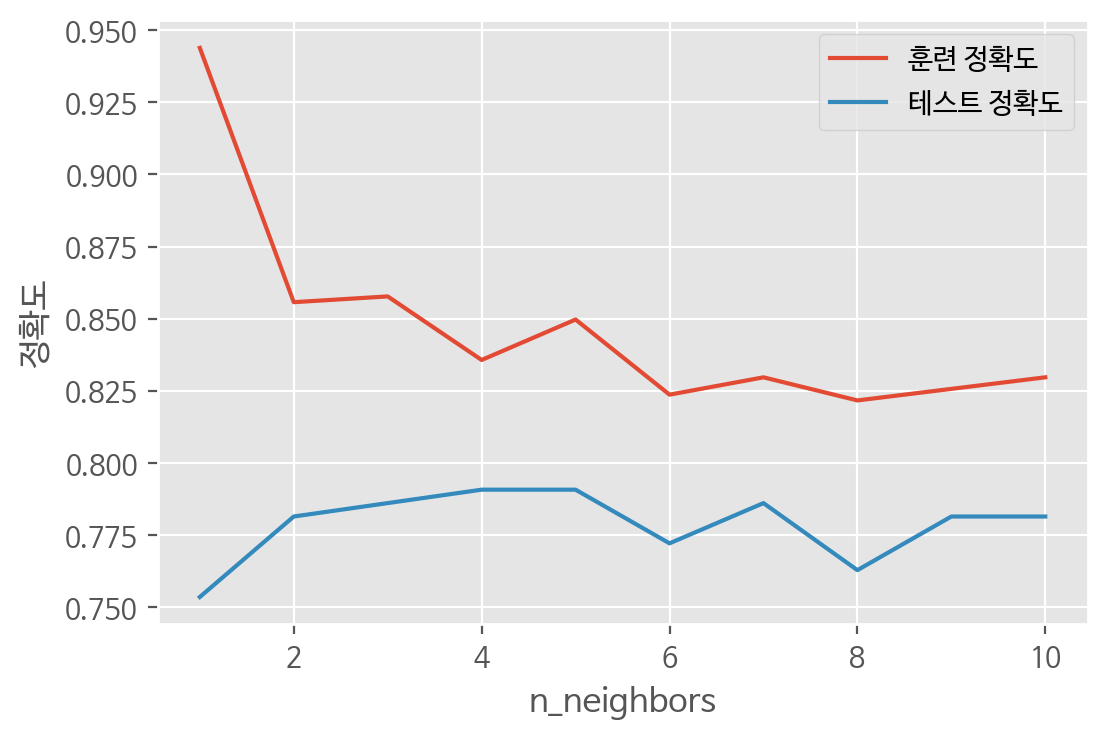

In [26]:
# 이웃의 수에 따른 정확도 저장할 리스트 변수
train_accuracy = []
test_accuracy=[]

# 1에서 10까지 n_neighbors를 적용
neighbors_settings = range(1,11)

for n_neighbors in neighbors_settings :
  #모델 생성
  clf = KNeighborsClassifier(n_neighbors=n_neighbors)
  clf.fit(X_train,y_train)

  # 훈련 세트 정확도 저장
  train_accuracy.append(clf.score(X_train,y_train))

  # 테스트 세트 정확도 저장
  test_accuracy.append(clf.score(X_test,y_test))
  
# 훈련 VS 테스트 정확도 시각화
plt.figure(dpi=100)
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic') 
plt.plot(neighbors_settings,train_accuracy,label='훈련 정확도')
plt.plot(neighbors_settings,test_accuracy,label='테스트 정확도')
plt.ylabel("정확도")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

k-Neighbors Regression
* k=1 경우 그냥 가장 가까운 이웃의 타켓값
* k >=2 경우 회귀분석 -> 여러 개의 최근접 이웃 간의 평균(average or mean)이 예측 값


wave 데이터셋을 사용하여 이웃의 수(결정경계)에 따라 성능 평가

데이터 셋 분리하기(훈련셋,테스트셋)

In [29]:
pip install mglearn

     |████████████████████████████████| 542kB 15.1MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=4afe32c7a3f7a91268b12865f0ffc42eefb50dc488194b356c9ab0cdbc625db4
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import mglearn
X,y = mglearn.datasets.make_wave(n_samples =40)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [36]:
# 이웃의 수는 3으로 하여 모델 객체를 생성
reg = KNeighborsRegressor(n_neighbors=3)

In [37]:
reg.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

성능평가 하기

In [38]:
reg.score(X_test,y_test)

0.8344172446249604

In [39]:
# score r-square 결정계수 0~1 사이 값을 갖고, 관계가 높을 수록 1에 가까운 값을 갖음
# 0에 가까울 수록 데이터 분포를 제대로 표현하지 못한것
print("테스트 세트 R^2 : {:.2f}".format(reg.score(X_test,y_test)))

테스트 세트 R^2 : 0.83


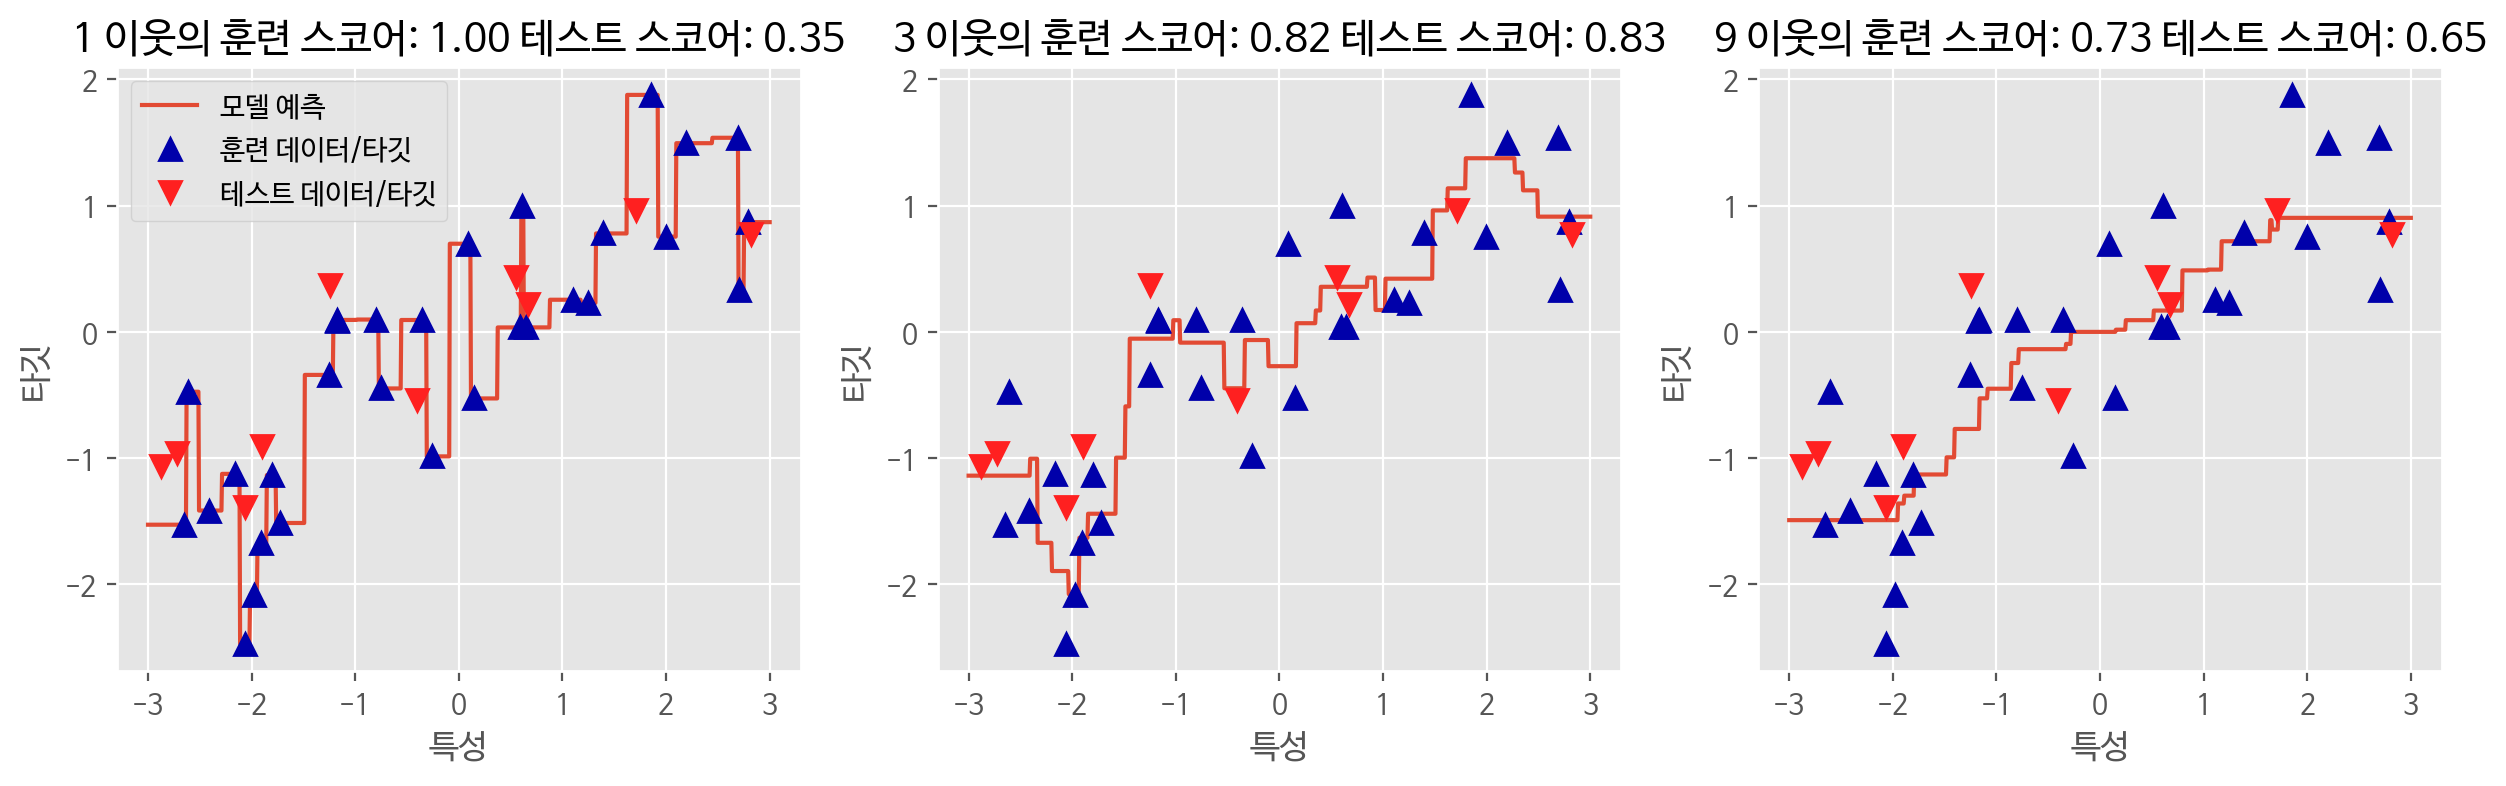

In [41]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4),dpi = 100)
plt.rc('font', family ='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# -3 과 3 사이에 1,000 개의 데이터 포인트를 만듭니다
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # 1, 3, 9 이웃을 사용한 예측을 합니다
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)

    ax.set_title(
        "{} 이웃의 훈련 스코어: {:.2f} 테스트 스코어: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train), reg.score(X_test, y_test)))
    ax.set_xlabel("특성")
    ax.set_ylabel("타깃")
    
axes[0].legend(["모델 예측", "훈련 데이터/타깃", "테스트 데이터/타깃"], loc="best")
plt.show()


선형 모델 : 선형 함수를 만들어 예측 수행

선형 회귀 모델

w[0]: 0.393906  b: -0.031804


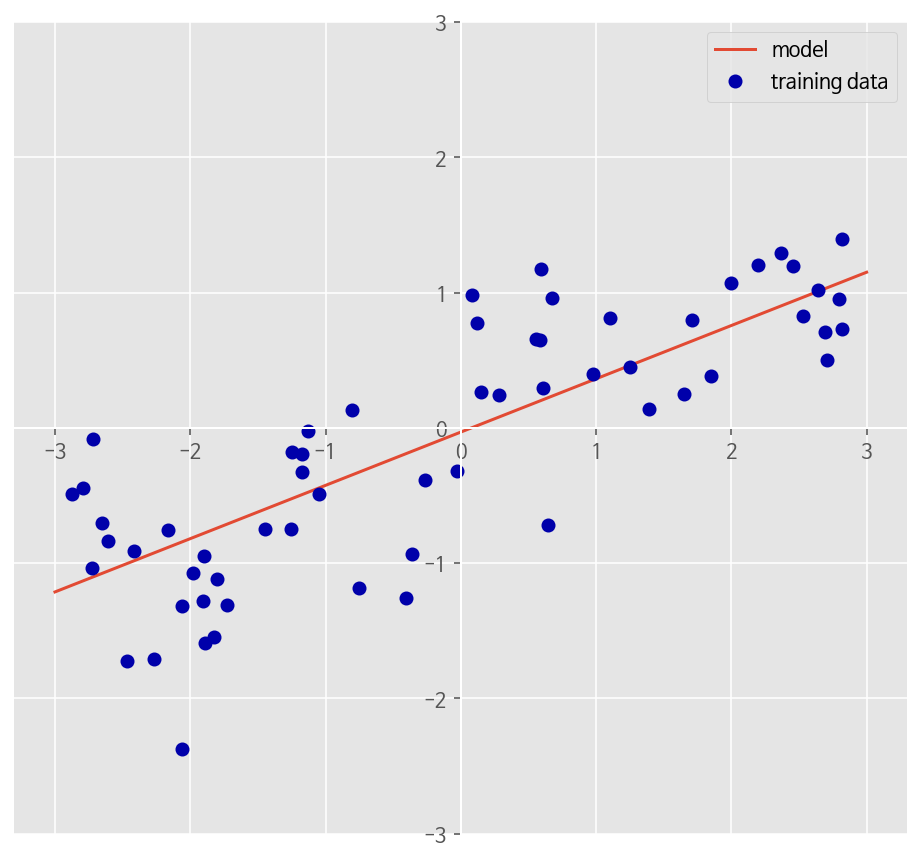

In [42]:
mglearn.plots.plot_linear_regression_wave()

선형회귀(최소제곱법)

데이터 준비하기

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X,y=mglearn.datasets.make_wave(n_samples=60)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

선형모델 만든 후 학습시키기

In [44]:
lr = LinearRegression().fit(X_train,y_train)

In [47]:
print("lr.coef_ : ",lr.coef_) # 가중치,기울기
print("lr.intercept_ : ",lr.intercept_) # 절편

lr.coef_ :  [0.39390555]
lr.intercept_ :  -0.031804343026759746


In [50]:
print("훈련 세트 점수:",lr.score(X_train,y_train))
print("테스트 세트 점수:",lr.score(X_test,y_test))

훈련 세트 점수: 0.6700890315075756
테스트 세트 점수: 0.65933685968637


보스턴 주택가격 데이터셋을 사용한 선형 회귀 성능 평가

In [52]:
X,y = mglearn.datasets.load_extended_boston()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

훈련 데이터셋으로 학습하기

In [53]:
lr=LinearRegression().fit(X_train,y_train)

성능 평가하기

In [55]:
print("훈련 세트 점수:",lr.score(X_train,y_train))
print("테스트 세트 점수:",lr.score(X_test,y_test))

훈련 세트 점수: 0.9448313975211592
테스트 세트 점수: 0.7758378393351728


릿지 회귀 -> 규제를 통해서 과대적합 되지 않게 하기 위한 선형 모델

In [59]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train,y_train) # alpha = 1.0

성능 평가

In [57]:
print("훈련 세트 점수:",ridge.score(X_train,y_train))
print("테스트 세트 점수:",ridge.score(X_test,y_test))

훈련 세트 점수: 0.8700969775259914
테스트 세트 점수: 0.8145421818415548


alpha 매개변수를 통해 모델 설정

In [58]:
ridge10 = Ridge(alpha=10).fit(X_train,y_train)
print("훈련 세트 점수:",ridge10.score(X_train,y_train))
print("테스트 세트 점수:",ridge10.score(X_test,y_test))

훈련 세트 점수: 0.7669532344928074
테스트 세트 점수: 0.7279392273706594


In [60]:
ridge01 = Ridge(alpha=0.1).fit(X_train,y_train)
print("훈련 세트 점수:",ridge01.score(X_train,y_train))
print("테스트 세트 점수:",ridge01.score(X_test,y_test))

훈련 세트 점수: 0.9174870139232223
테스트 세트 점수: 0.8246491875314637


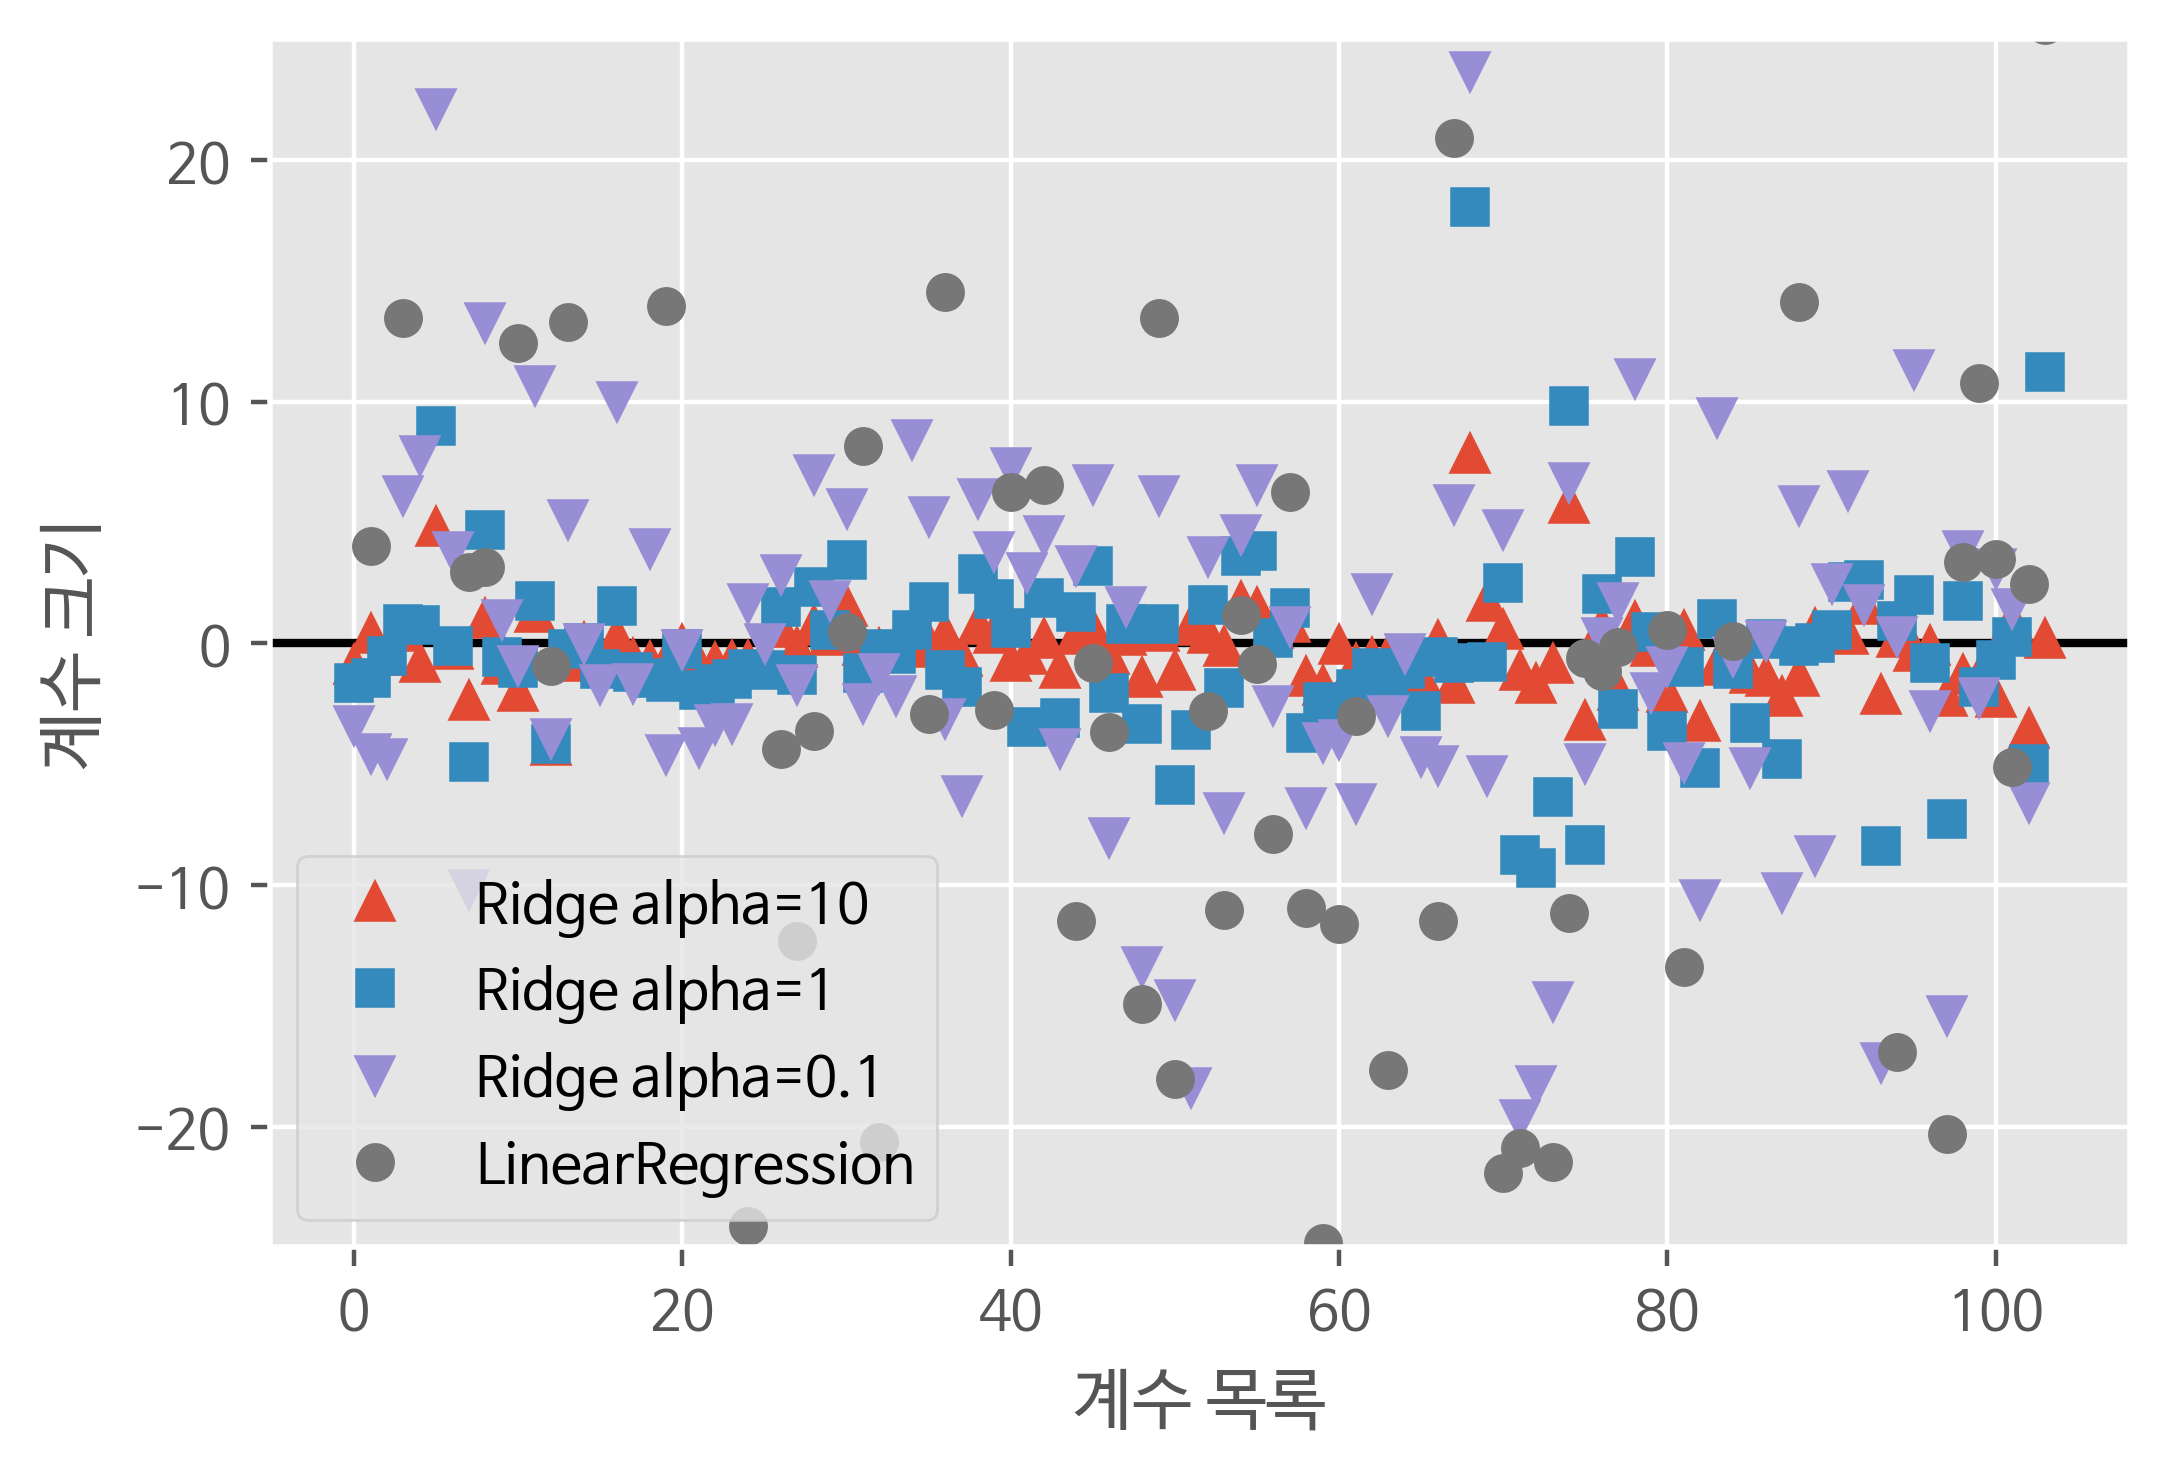

In [61]:
plt.rc('font', family ='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(dpi = 200)

plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")

plt.plot(lr.coef_, 'o', label="LinearRegression")
plt.xlabel("계수 목록")
plt.ylabel("계수 크기")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-25, 25)
plt.legend()
plt.show()


Lasso

확장된 보스턴 주택가격 데이터셋에 라쏘를 적용

In [63]:
from sklearn.linear_model import Lasso
import numpy as np

lasso = Lasso().fit(X_train,y_train)
print("훈련 세트 점수:",lasso.score(X_train,y_train))
print("테스트 세트 점수:",lasso.score(X_test,y_test))
print("사용한 특성의 개수: ",np.sum(lasso.coef_ !=0))

훈련 세트 점수: 0.26783778369518485
테스트 세트 점수: 0.2599232118344591
사용한 특성의 개수:  3


In [65]:
lasso001 =Lasso(alpha=0.01).fit(X_train,y_train)
print("훈련 세트 점수:",lasso001.score(X_train,y_train))
print("테스트 세트 점수:",lasso001.score(X_test,y_test))
print("사용한 특성의 개수: ",np.sum(lasso001.coef_ !=0))

훈련 세트 점수: 0.8865033777946089
테스트 세트 점수: 0.80359225764207
사용한 특성의 개수:  34


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8481333641448145, tolerance: 3.361037625329816
  positive)
